In [1]:
from copy import copy
import numpy as np
import os
import datetime
from baselines.utils import (
    load_stdata, remove_incomplete_days, evaluate, plot_region_data, save_to_csv
)
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gds

2023-03-23 12:48:42.350112: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-23 12:48:42.357893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 12:48:42.357911: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/gpu2/.local/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [3]:
#DATAPATH = 'results/feat_sosta_media_contemporanea_1h.h5'
#DATAPATH = 'results/feat_mean_time_1h.h5'

# load transfer learning data

DATAPATH = 'results_one_month/feat_CNN_sosta_media_contemporanea_1h.h5'


nb_flow = 1 # i.e. inflow and outflow
T = 24 # number timestamps per day
days_test = 122
# load data
fname = os.path.join(DATAPATH)
print("file name: ", fname)
data, timestamps = load_stdata(fname)
# print(timestamps)
# remove a certain day which does not have 24 timestamps
#data, timestamps = remove_incomplete_days(data, timestamps, T)
#data = data[:, :nb_flow]
data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
data = data[:, :nb_flow, :, :]
data[data < 0] = 0
print('data shape: ' + str(data.shape))

file name:  results_one_month/feat_CNN_sosta_media_contemporanea_1h.h5
data shape: (743, 1, 54, 43)


In [4]:
data.max()

177.3525179856115

In [5]:
data.mean()

16.368295768843716

In [6]:
# Configurazione per estrarre predetti e reali per il pomeriggio
def estrazione_pomeriggio(x):
    for i in range(14, len(x), 24):
        if i == 14:
            b = x[i:i+8]
        else:
            b = np.concatenate((b, x[i:i+8] ), axis=0)
    return b

# Configurazione per estrarre predetti e reali per la mattina
def estrazione_mattina(x):
    for i in range(6, len(x), 24):
        if i == 6:
            b = x[i:i+8]
        else:
            b = np.concatenate((b, x[i:i+8] ), axis=0)
    return b

# Configurazione per estrarre predetti e reali per la notte
def estrazione_notte(x):
    print(len(x))
    for i in range(0, len(x), 24):
        if i == 0:
            b = x[i:i+6]
            b = np.concatenate((b, x[i+22:i+25]), axis = 0)
        else:
            b = np.concatenate((b, x[i:i+6]), axis = 0)
            b = np.concatenate((b, x[i+22:i+25]), axis = 0)
    return b

In [7]:
def variance(data, T):
    num_rows, num_columns = data.shape[2], data.shape[3]

    data_variance = (data.shape[2], data.shape[3])
    data_variance = np.empty(data_variance)
    
    data_std = (data.shape[2], data.shape[3])
    data_std = np.empty(data_std)

    for flow in [0]:
        for row in range(num_rows):
            for column in range(num_columns):
                history_region = [x[flow][row][column] for x in data]
                history_region = np.array(history_region)
                #print(history_region.mean())
                #print(history_region.max())
                data_variance[row][column] = np.var(history_region)
                data_std[row][column] = np.std(history_region)
                #print(f'flow {flow}, region {row}x{column}, standard {np.var(history_region)}')
    
    return data_variance, data_std

In [8]:
data_variance, data_std = variance(data, T)

In [9]:
data_variance.max()

605.6032693729966

In [10]:
data_std.max()

24.609007890871922

In [11]:
np.median(data_variance)

532.898896832145

In [12]:
data_variance.mean()

529.8616344329398

In [13]:
np.median(data_std)

23.084603025221355

In [14]:
data_std.mean()

23.01102644760769

In [15]:
cv = data_std.mean()/data.mean()
cv

1.405829096234203

In [15]:
np.reshape(data_variance, (data_variance.shape[0]*data_variance.shape[1])).shape

(2322,)

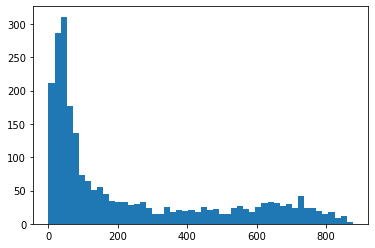

In [18]:
#n, bins, patches = 
plt.hist(np.reshape(data_variance, (data_variance.shape[0]*data_variance.shape[1])), bins = 50)
plt.show()
#plt.savefig('distruzione_varianza.png')

### Creazione dell'immagine 

In [14]:
def plot_image(image, flow, cmap, vmax, vmin=0, dt=None):
    # image *= (255.0/image.max())
    im = plt.imshow(image, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    fl = 'Inflow'
    if (dt):
        plt.title(dt.strftime(f'%a %d %B %Y, %H:%M ({fl})'))

In [15]:
data_variance.max()

877.119975628558

In [16]:
data_variance.shape

(54, 43)

TypeError: Invalid shape (21,) for image data

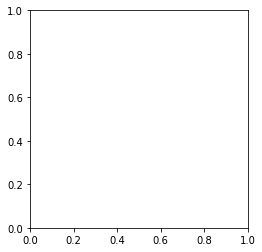

In [17]:
fig = plt.figure()
plot_image(data_std[data_std == 0], 0, 'seismic', data_std.max(), -data_std.min())
plt.title('Standard deviation distribution')
plt.show()
#fig.savefig('distruzione_standard_su_mappa.png', bbox_inches='tight')

# Varianza in base alla fascia oraria 

In [20]:
# Mattina
data_m = estrazione_mattina(data)
print(data_m.shape)
data_variance, data_std = variance(data_m, T)

(2920, 1, 54, 43)


In [21]:
data_variance.max()

868.7090846170832

In [22]:
data_std.max()

29.473871218709686

In [23]:
np.median(data_variance)

98.93360307648598

In [24]:
data_variance.mean()

226.3128256402565

In [25]:
np.median(data_std)

9.946536052471117

In [26]:
data_std.mean()

12.663032209266468

In [27]:
np.reshape(data_variance, (data_variance.shape[0]*data_variance.shape[1])).shape

(2322,)

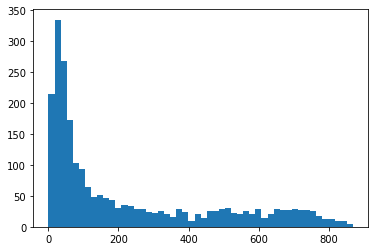

In [28]:
#n, bins, patches = 
plt.hist(np.reshape(data_variance, (data_variance.shape[0]*data_variance.shape[1])), bins = 50)
plt.show()
#plt.savefig('distruzione_varianza.png')

In [29]:
# Pomeriggio
data_p = estrazione_pomeriggio(data)
print(data_p.shape)
data_variance, data_std = variance(data_p, T)

(2920, 1, 54, 43)


In [30]:
data_variance.max()

872.9485516346407

In [31]:
data_std.max()

29.54570276088624

In [32]:
np.median(data_variance)

96.05798129853162

In [33]:
data_variance.mean()

223.25608199109297

In [34]:
np.median(data_std)

9.800913648286896

In [35]:
data_std.mean()

12.587087279934929

In [36]:
np.reshape(data_variance, (data_variance.shape[0]*data_variance.shape[1])).shape

(2322,)

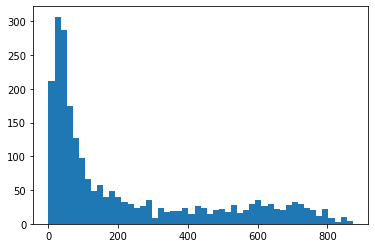

In [37]:
#n, bins, patches = 
plt.hist(np.reshape(data_variance, (data_variance.shape[0]*data_variance.shape[1])), bins = 50)
plt.show()
#plt.savefig('distruzione_varianza.png')

In [38]:
# Pomeriggio
data_n = estrazione_notte(data)
print(data_n.shape)
data_variance, data_std = variance(data_n, T)

8759
(3283, 1, 54, 43)


In [39]:
data_variance.max()

893.9163727911321

In [40]:
data_std.max()

29.898434286616617

In [41]:
np.median(data_variance)

47.57614601252597

In [42]:
data_variance.mean()

192.99030492058137

In [43]:
np.median(data_std)

6.897544698559282

In [44]:
data_std.mean()

10.628265395886242

In [45]:
np.reshape(data_variance, (data_variance.shape[0]*data_variance.shape[1])).shape

(2322,)

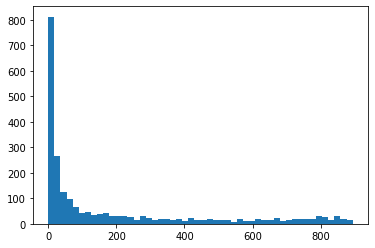

In [46]:
#n, bins, patches = 
plt.hist(np.reshape(data_variance, (data_variance.shape[0]*data_variance.shape[1])), bins = 50)
plt.show()
#plt.savefig('distruzione_varianza.png')

In [217]:
path1 = 'data/istat/dati-cpa_2011/Sezioni-di-Censimento/combined_csv.csv' # va bene anche per roma
path2 = 'data/istat/ASC2011_WGS84/Roma/ASC_RomaSuddivisioni.xlsx'
fp = 'data/istat/R12_11_WGS84/R12_11_WGS84.shp'
pathShapeF='data/shapefile/shapefile_2323.shp'
path3 = 'data/istat/ASC2011_WGS84/Italia/ASC2011_WGS84.shp'

In [218]:
def db_creation(path1, path2, fp):
    db1 = pd.read_csv(path1, sep=';')
    db2 = pd.read_excel(path2)
    db3 = gds.read_file(fp)
    # Unione del dataset per ottenere quello di milano
    #db1 = db1.merge(db2, left_on='SEZ2011', right_on='SEZ2011', how='inner')
    # Aggiunta delle coordinate geografiche al dataset
    db1 = db1.merge(db3[['geometry', 'SEZ2011']], left_on='SEZ2011', right_on='SEZ2011', how='right')
    return db1, db3

In [219]:
dataset, db1 = db_creation(path1, path2, fp)

In [220]:
dataset['Popolazione_giusta'] = dataset.P18 + dataset.P19 + dataset.P20 + dataset.P21 + dataset.P22 + dataset.P23 #+ dataset.P24 + dataset.P25

In [221]:
# preparazione dei dataset 
#census = gds.GeoDataFrame(dataset[['P1', 'geometry']]).to_crs("epsg:4326")
census = gds.GeoDataFrame(dataset[['Popolazione_giusta', 'geometry']]).to_crs("epsg:4326")
census2 = census.copy()
census3 = gds.GeoDataFrame(dataset[['P1','P47', 'geometry']]).to_crs("epsg:4326")

In [222]:
shapefile = gds.read_file(pathShapeF).set_crs(epsg=4326)

In [223]:
#oout = gds.GeoDataFrame(out).set_crs(epsg=4326)

In [224]:
### Census pesato

In [225]:
census2['Area_finale'] = census2['geometry'].to_crs({'init': 'epsg:3395'}).map(lambda p: p.area / 10**6)

/home/gpu2/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

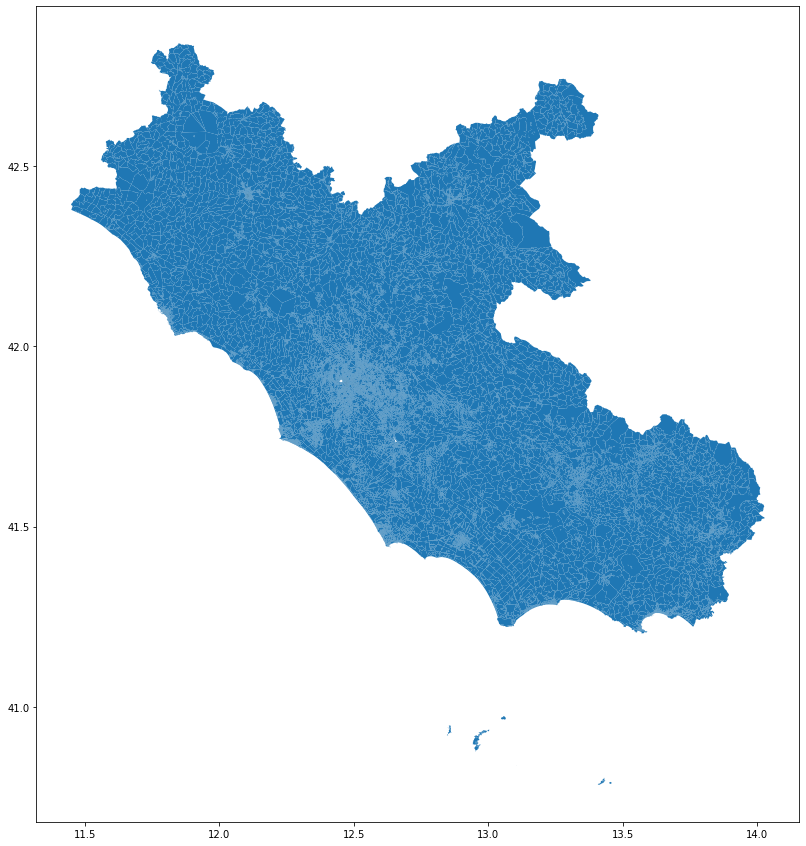

In [226]:
census2.plot()

In [227]:
outflow = gds.overlay(shapefile, census2, how='intersection')
outflow['Area'] = outflow['geometry'].to_crs({'init': 'epsg:3395'}).map(lambda p: p.area / 10**6)
outflow['proporzione'] = round(outflow['Area'] / outflow['Area_finale'],2)
outflow['popolazione_proporzionata'] = outflow.proporzione * outflow.Popolazione_giusta

/home/gpu2/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [176]:
#de = [i for i in range(2322)]
#e = outflow['FID'].unique()
#e.sort()

In [211]:
#a = pd.DataFrame(de).rename(columns={0:'casa'}).merge(pd.DataFrame(e), left_on='casa', right_on=0, how='left')

In [214]:
#a[a[0].isnull()]

,casa,0
5,5,NaN
1931,1931,NaN
1946,1946,NaN
1954,1954,NaN
1955,1955,NaN
1956,1956,NaN
1985,1985,NaN
1986,1986,NaN
1987,1987,NaN
2039,2039,NaN


In [228]:
outflow[outflow['Popolazione_giusta'].isnull()].head(40)

,FID,Popolazione_giusta,Area_finale,geometry,Area,proporzione,popolazione_proporzionata
78,2,NaN,0.091152,"POLYGON ((12.38073 41.79764, 12.38125 41.79734...",0.017860,0.20,NaN
79,3,NaN,0.091152,"POLYGON ((12.38771 41.79536, 12.38768 41.79536...",0.023135,0.25,NaN
80,4,NaN,0.091152,"POLYGON ((12.38771 41.79567, 12.38822 41.79573...",0.004995,0.05,NaN
81,55,NaN,0.091152,"POLYGON ((12.37831 41.79831, 12.37802 41.79843...",0.029230,0.32,NaN
82,56,NaN,0.091152,"POLYGON ((12.37987 41.79764, 12.37939 41.79787...",0.015932,0.17,NaN
83,2,NaN,0.753262,"POLYGON ((12.38149 41.79764, 12.38172 41.79753...",0.016252,0.02,NaN
84,3,NaN,0.753262,"POLYGON ((12.38771 41.79567, 12.38738 41.79562...",0.051526,0.07,NaN
85,4,NaN,0.753262,"POLYGON ((12.39209 41.79764, 12.39192 41.79754...",0.037203,0.05,NaN
86,54,NaN,0.753262,"POLYGON ((12.37092 41.80234, 12.37167 41.80205...",0.025354,0.03,NaN
87,55,NaN,0.753262,"POLYGON ((12.37831 41.79881, 12.37791 41.79899...",0.038535,0.05,NaN


In [229]:
outflow[outflow['FID'] == 2154]

,FID,Popolazione_giusta,Area_finale,geometry,Area,proporzione,popolazione_proporzionata
21689,2154,NaN,3.897616,"POLYGON ((12.59921 41.98094, 12.59921 41.97624...",0.366863,0.09,NaN


<AxesSubplot:>

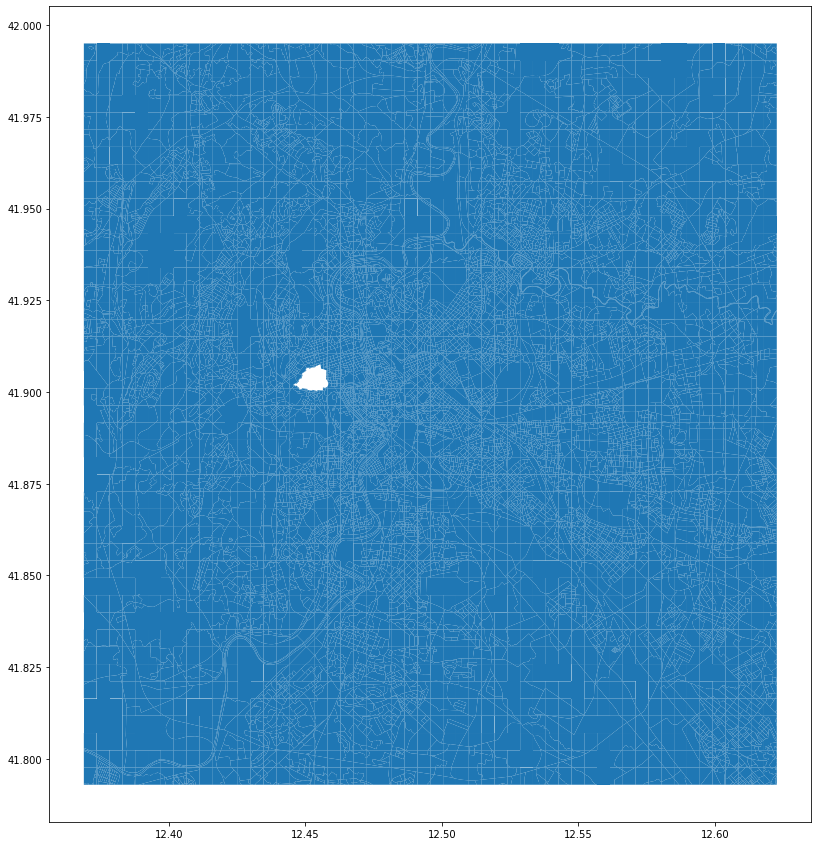

In [130]:
outflow.plot()

In [230]:
outflow

,FID,Popolazione_giusta,Area_finale,geometry,Area,proporzione,popolazione_proporzionata
0,0,56.0,0.121467,"MULTIPOLYGON (((12.37185 41.79294, 12.37225 41...",0.010070,0.08,4.48
1,0,12.0,0.008064,"POLYGON ((12.37269 41.79510, 12.37272 41.79521...",0.008064,1.00,12.00
2,0,120.0,0.106528,"POLYGON ((12.37361 41.79294, 12.37241 41.79294...",0.054065,0.51,61.20
3,1,120.0,0.106528,"POLYGON ((12.37361 41.79294, 12.37361 41.79727...",0.028635,0.27,32.40
4,0,5.0,1.965340,"POLYGON ((12.37361 41.79764, 12.37361 41.79727...",0.293605,0.15,0.75
...,...,...,...,...,...,...,...
22812,2320,324.0,0.087541,"POLYGON ((12.61584 41.99504, 12.61471 41.99466...",0.003457,0.04,12.96
22813,2320,404.0,0.105108,"POLYGON ((12.61801 41.99504, 12.61801 41.99482...",0.000696,0.01,4.04
22814,2321,404.0,0.105108,"POLYGON ((12.62090 41.99504, 12.62004 41.99424...",0.042315,0.40,161.60
22815,2321,823.0,0.377553,"POLYGON ((12.62271 41.99504, 12.62271 41.99420...",0.071154,0.19,156.37


In [231]:
len(outflow['FID'].unique())

2322

In [234]:
test = outflow.groupby('FID')['popolazione_proporzionata'].sum().to_frame().reset_index()
test[test['FID']==2154]

,FID,popolazione_proporzionata
2154,2154,0.0


In [ ]:
outflow

In [13]:
fin_out = out.merge(outflow.groupby('prec_placename')['popolazione_proporzionata'].sum().to_frame().reset_index())

NameError: name 'out' is not defined

<AxesSubplot:>

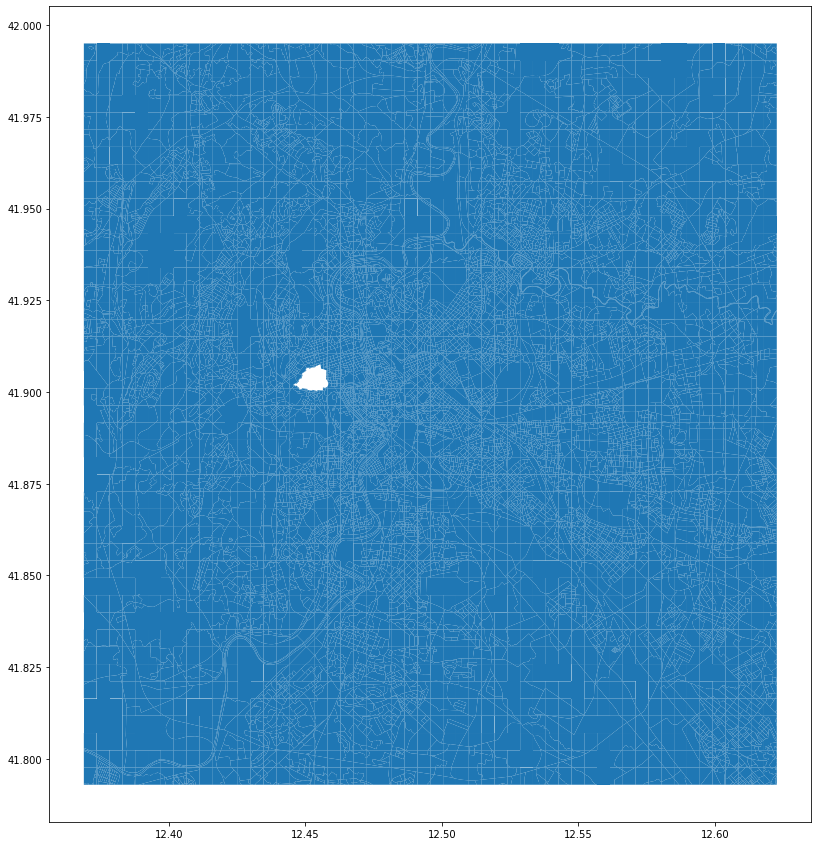

In [235]:
plt.rcParams["figure.figsize"] = (15,15)
outflow.plot()